In [1]:
from glob import glob
import napari
import numpy as np
from pathlib import Path
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from bioio import BioImage
import  bioio_bioformats
import seaborn as sns

In [7]:
files = glob(f'*.vsi')
files

['D197198_SSUQ5_670_1_CY5, CY3, DAPI.vsi',
 'D197198_SSUQ5_670_RNASE_1_CY5, CY3, DAPI.vsi',
 'D197198_SSUQ570_01_CY5, CY3, DAPI.vsi',
 'D197198_SSUQ670_2_CY5, CY3, DAPI.vsi']

In [ ]:
img = BioImage(files[0], reader=bioio_bioformats.Reader)
img = img.data
img_max = np.amax(img[:,:,4:-4,:,:],axis=2)
img_channels= np.squeeze(img_max)

In [ ]:
crop = img_channels[:,500:1500,500:1500]

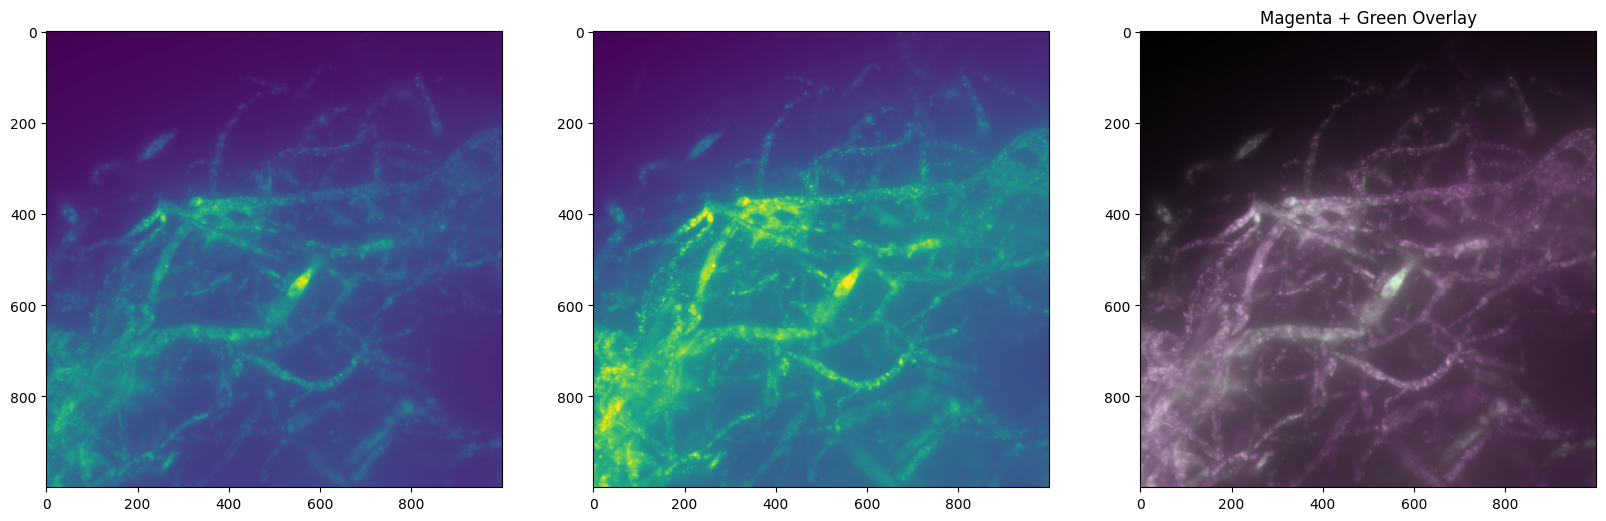

In [28]:
green = crop[0]
magenta = crop[1]

# Normalize if needed
def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

green = normalize(green)
magenta = normalize(magenta)


alpha_magenta = 0.8
alpha_green = 1
# Create RGB image: green to G, magenta to R+B
rgb_image = np.zeros((*green.shape, 3))
rgb_image[..., 0] = magenta * alpha_magenta  # Red
rgb_image[..., 1] = green   * alpha_green # Green
rgb_image[..., 2] = magenta  * alpha_magenta# Blue

# Display
fig,ax= plt.subplots(ncols = 3, figsize=(20,20))
ax[0].imshow(green)
ax[1].imshow(magenta)
ax[2].imshow(rgb_image)
#plt.axis('off')
ax[2].set_title("Magenta + Green Overlay")
plt.show()

In [40]:
img_channels[0].max()

62771

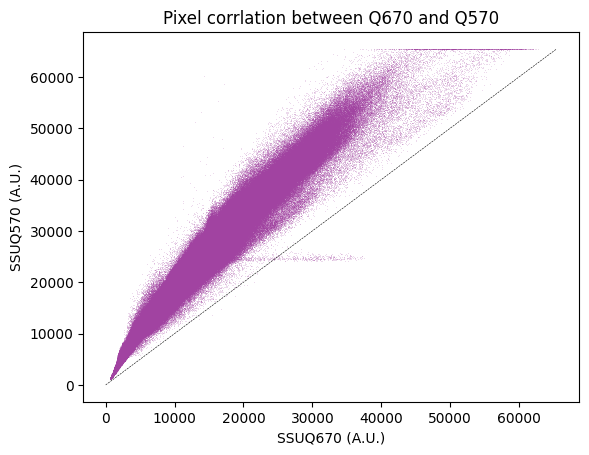

In [48]:
fig,ax = plt.subplots()
ax.plot([0, img_channels[1].max()], [0, img_channels[1].max()], ls="--", c="black",lw=0.4)
ax = sns.scatterplot(x=img_channels[0].ravel(),y=img_channels[1].ravel(),s = 0.1, color='purple')
ax.set_ylabel('SSUQ570 (A.U.)')
ax.set_xlabel('SSUQ670 (A.U.)')
ax.set_title('Pixel corrlation between Q670 and Q570')
plt.savefig('Pixel corrlation between Q670 and Q570.png')

***

In [56]:
def extract_exposure_times_image(file):
    
    # Access the raw OME metadata
    img = BioImage(file, reader=bioio_bioformats.Reader)
    ome_metadata = img.reader.metadata
    img_metadata = ome_metadata.images[img.current_scene_index]
    
    # Assume: 'image' is your OME Image object
    planes = img_metadata.pixels.planes
    channels = img_metadata.pixels.channels
    
    # Map channel index → exposure time (only first one per channel)
    channel_exposure = {}
    
    for plane in planes:
        c_idx = plane.the_c
        print(plane.exposure_time)
        if c_idx is not None and c_idx not in channel_exposure:
            channel_exposure[c_idx] = plane.exposure_time
    
    # Print results
    print(file)
    for c_idx, exposure in sorted(channel_exposure.items()):
        name = channels[c_idx].name
        print(f"{name}: {exposure} s")

In [8]:
img_dict = {}
for file in files:
    img = BioImage(file, reader=bioio_bioformats.Reader)
    img = img.data
    img_max = np.amax(img[:,:,4:-4,:,:],axis=2)
    img_channels= np.squeeze(img_max)
    img_dict[file] = img_channels 

In [14]:
mylist = list(img_dict.keys())[::-1]
myorder = [0,1,3,2]
mylist = [mylist[i] for i in myorder]
mylist

['D197198_SSUQ670_2_CY5, CY3, DAPI.vsi',
 'D197198_SSUQ570_01_CY5, CY3, DAPI.vsi',
 'D197198_SSUQ5_670_1_CY5, CY3, DAPI.vsi',
 'D197198_SSUQ5_670_RNASE_1_CY5, CY3, DAPI.vsi']

In [16]:
names = ['Q670',
        'Q570',
        'Q670 + Q570 ',
        'RNAse treatment + Q670/Q570']

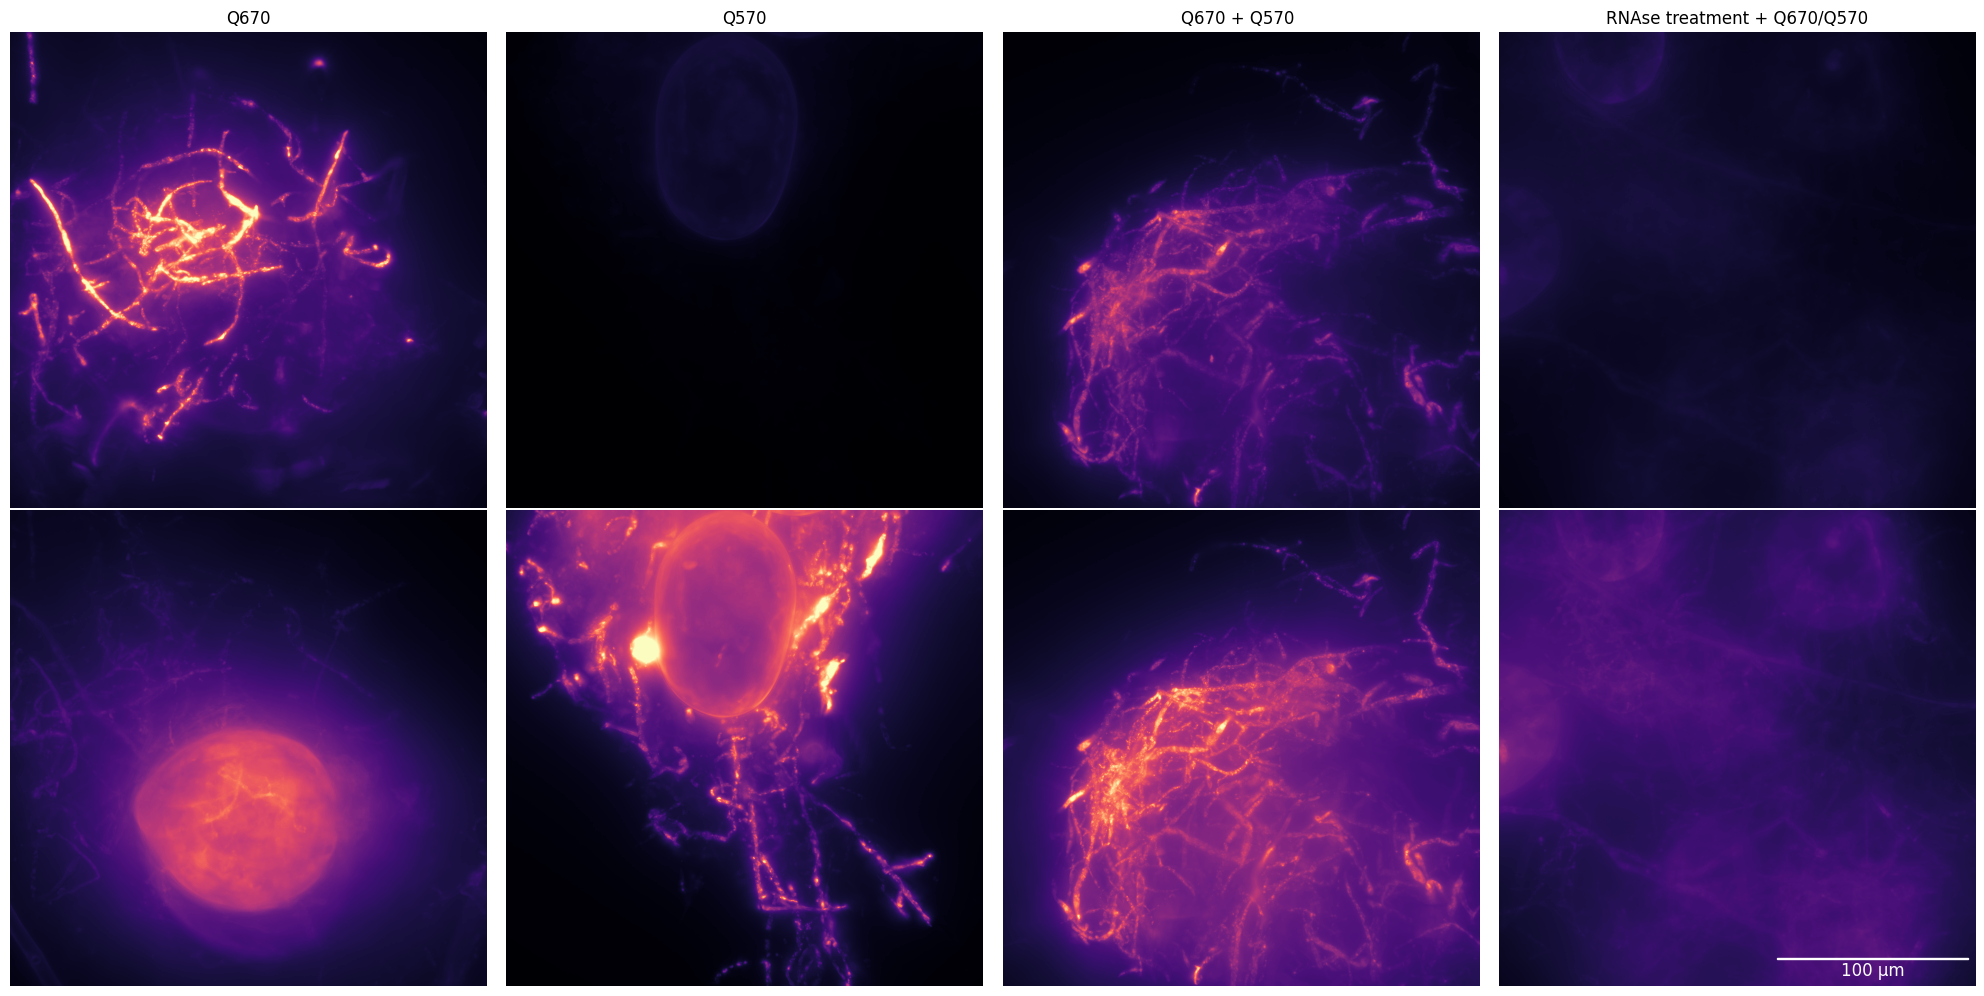

In [25]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.transforms import Bbox
import matplotlib.font_manager as fm

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
scalebar_length_um = 100  # length of scalebar in microns
pixel_size_um = 0.108
scalebar_length_px = scalebar_length_um / pixel_size_um  # ≈ 92.6
fontprops = fm.FontProperties(size=12)

for i, key in enumerate(mylist):
    channels = img_dict[key]
    for j, channel in enumerate(channels):
        if j == 2:
            continue
        if j == 0:
            vmin, vmax = 0, 65446
            ax[j, i].set_title(names[i])
        elif j == 1:
            vmin, vmax = 0, 65446

        ax[j, i].axis('off')
        ax[j, i].imshow(channel, vmin=vmin, vmax=vmax, cmap='magma')

# Add scalebar to the bottom-left of each subplot
scalebar = AnchoredSizeBar(ax[1, 3].transData,
                           scalebar_length_px, f'{scalebar_length_um} µm',
                           'lower right', 
                           pad=0.3,
                           color='white',
                           frameon=False,
                           size_vertical=3,
                           fontproperties=fontprops)
ax[1, 3].add_artist(scalebar)
plt.tight_layout()

plt.savefig('probe_comparison.png',dpi=600)